In [1]:
%matplotlib inline
import warnings

warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import mdtraj as md

In [3]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
# import tidynamics as td

In [4]:
traj = md.load('data/traj_3.xtc',top= 'data/water_top.pdb')


In [5]:
com = md.compute_center_of_mass(traj)

In [6]:
com.shape

(10000001, 3)

In [7]:
df = pd.DataFrame(com, columns=['1', '2', '3'])
df['t'] = traj.time/1000

In [8]:
df_melt = pd.melt(frame=df, id_vars=['t'], value_vars=['1', '2', '3'], var_name='coord', )

In [9]:
df_melt.head()

t coord     value
0  0.0000     1  2.322035
1  0.0001     1  2.317498
2  0.0002     1  2.348874
3  0.0003     1  2.367788
4  0.0004     1  2.341420

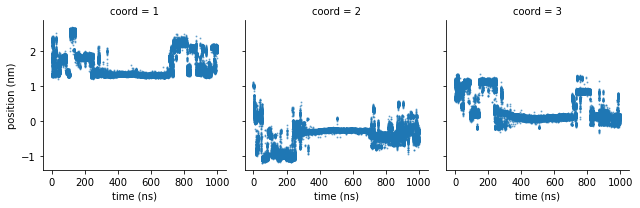

In [10]:
g = sns.FacetGrid(df_melt.iloc[::100,:], col='coord')
g.map(plt.scatter, 't', 'value', alpha=0.5, s=1)
g.set_axis_labels('time (ns)', 'position (nm)')

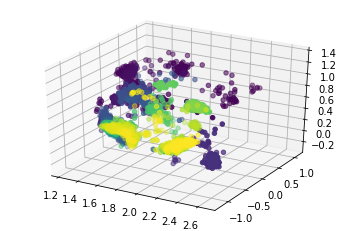

In [11]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter(xs=com[::1000,0], ys=com[::1000,1], zs=com[::1000,2], c=df['t'][::1000])



## Moving window analysis

### Histogram window parameters

In [12]:
dt = traj.timestep/1000
window = 1 # window size in ns
nrows= int(window/dt)
n_splits = com.shape[0]//nrows

In [13]:
com_split = np.array_split(com, n_splits)

### Test TICA parameters

In [104]:
tica_lags = np.array([(i+1)*int(0.01/dt) for i in range(25)]) # 0.1ns
print(tica_lags)
ndim = 3

[  99  198  297  396  495  594  693  792  891  990 1089 1188 1287 1386
 1485 1584 1683 1782 1881 1980 2079 2178 2277 2376 2475]


In [105]:
tica_objs = [coor.tica(com_split[0], lag=tica_lag, dim=ndim,  kinetic_map=False) for tica_lag in tica_lags]
timescales = np.vstack([tica.timescales for tica in tica_objs])


Text(0.5, 0, 'tica lag (ns)')

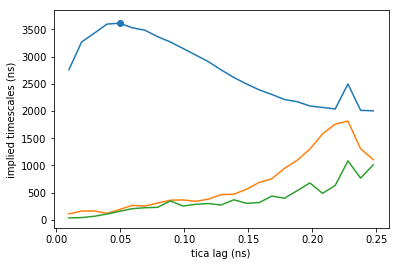

In [110]:
plt.plot(tica_lags*dt, timescales)
max_lag = tica_lags[np.argmax(timescales[:,0])]*dt
max_ts =  np.max(timescales[:,0])
plt.scatter(max_lag,max_ts)
plt.ylabel('implied timescales (ns)')
plt.xlabel('tica lag (ns)')

In [112]:
max_lag/dt

495.0

In [124]:
tica_objs = [coor.tica(traj, lag=int(max_lag/dt), dim=ndim,  kinetic_map=False) for traj in com_split]
tica_trajs = [x.get_output()[0] for x in tica_objs]
tica_vecs = [x.eigenvectors for x in tica_objs]
tica_vals = [x.eigenvalues for x in tica_objs]
# Y = [coor.tica(traj, lag=tica_lag, dim=ndim,  kinetic_map=True).get_output()[0] for traj in com_split]

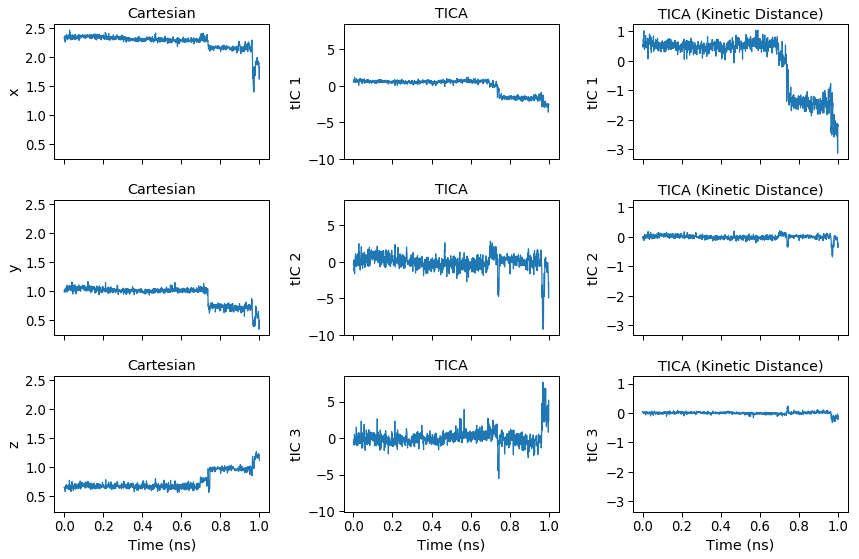

In [136]:
with sns.plotting_context('paper', font_scale=1.5):
    fig, axes = plt.subplots(3, 3, sharey='col', sharex=True, figsize=(12,8))
    idx = 0
    stride = 10
    time = np.arange(com_split[idx][::stride].shape[0])*dt*stride

    xyz_labs = ['x', 'y', 'z']
    tica_labs = ['tIC {}'.format(i+1) for i in range(3)]

    for i, ax in enumerate(axes[:,0]):
        ax.plot(time, com_split[idx][::stride, i])
        ax.set_ylabel(xyz_labs[i])
        ax.set_title('Cartesian')
        if i == 2: ax.set_xlabel('Time (ns)')

    for i, ax in enumerate(axes[:,1]):
        ax.plot(time, tica_trajs[idx][::stride, i])
        ax.set_ylabel(tica_labs[i])
        ax.set_title('TICA')
        if i == 2: ax.set_xlabel('Time (ns)')

    for i, ax in enumerate(axes[:,2]):
        ax.plot(time, tica_trajs[idx][::stride, i]*tica_vals[idx][i])
        ax.set_ylabel(tica_labs[i])
        ax.set_title('TICA (Kinetic Distance)')
        if i == 2: ax.set_xlabel('Time (ns)')

    # _ = [ax.plot(traj[:,i]) for j, traj in enumerate(com_split[:2]) for i, ax in enumerate(axes[:3,j])]
    # _ = [ax.plot(traj[:,i]) for j, traj in enumerate(tica_trajs[:2]) for i, ax in enumerate(axes[3:,j])]

    plt.tight_layout()

(95, 101)

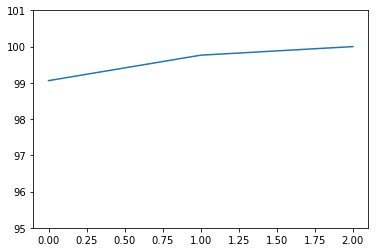

In [123]:
plt.plot(tica_objs[idx].cumvar*100)
plt.ylim(95,101)

In [15]:
tica_traj_segs = [[i+1, y.shape[0]] for i, y in enumerate(Y)]
tica_traj_segs[:10]

[[1, 10001],
 [2, 10000],
 [3, 10000],
 [4, 10000],
 [5, 10000],
 [6, 10000],
 [7, 10000],
 [8, 10000],
 [9, 10000],
 [10, 10000]]

In [16]:
tica_traj = np.concatenate(Y)
tica_traj.shape

(10000001, 3)

In [17]:
seg_num = np.concatenate([np.repeat(x, y) for x, y in tica_traj_segs])
seg_num.shape

(10000001,)

In [18]:
df_tica = pd.DataFrame(tica_traj, columns=['1', '2', '3'])
df_tica['seg'] = seg_num
df_tica['t'] = traj.time/1000
df_tica_melt = pd.melt(frame=df_tica, id_vars=['t', 'seg'], value_vars=['1', '2', '3'], var_name='coord')
df_tica_melt['projection'] = 'tica'
df_melt['seg']=1
df_melt['projection'] = 'xyz'
df_all = pd.concat([df_melt, df_tica_melt])

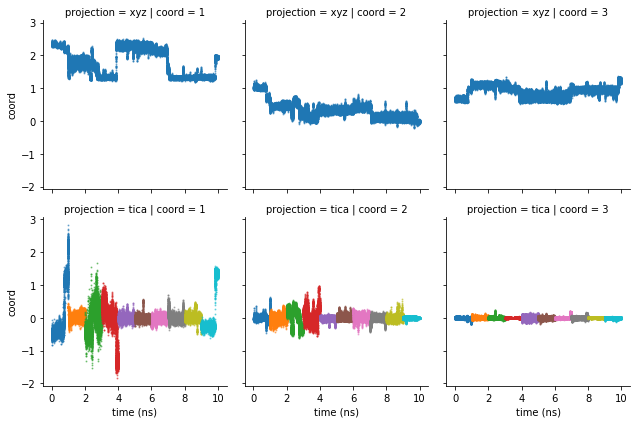

In [19]:
chunk = 10
start = 0
idx = (df_all['t']>start) & (df_all['t']<start+chunk)
g = sns.FacetGrid(df_all.loc[idx,:], col='coord',row='projection', hue='seg')
g.map(plt.scatter, 't', 'value', alpha=0.5, s=1)
g.set_axis_labels('time (ns)', 'coord')

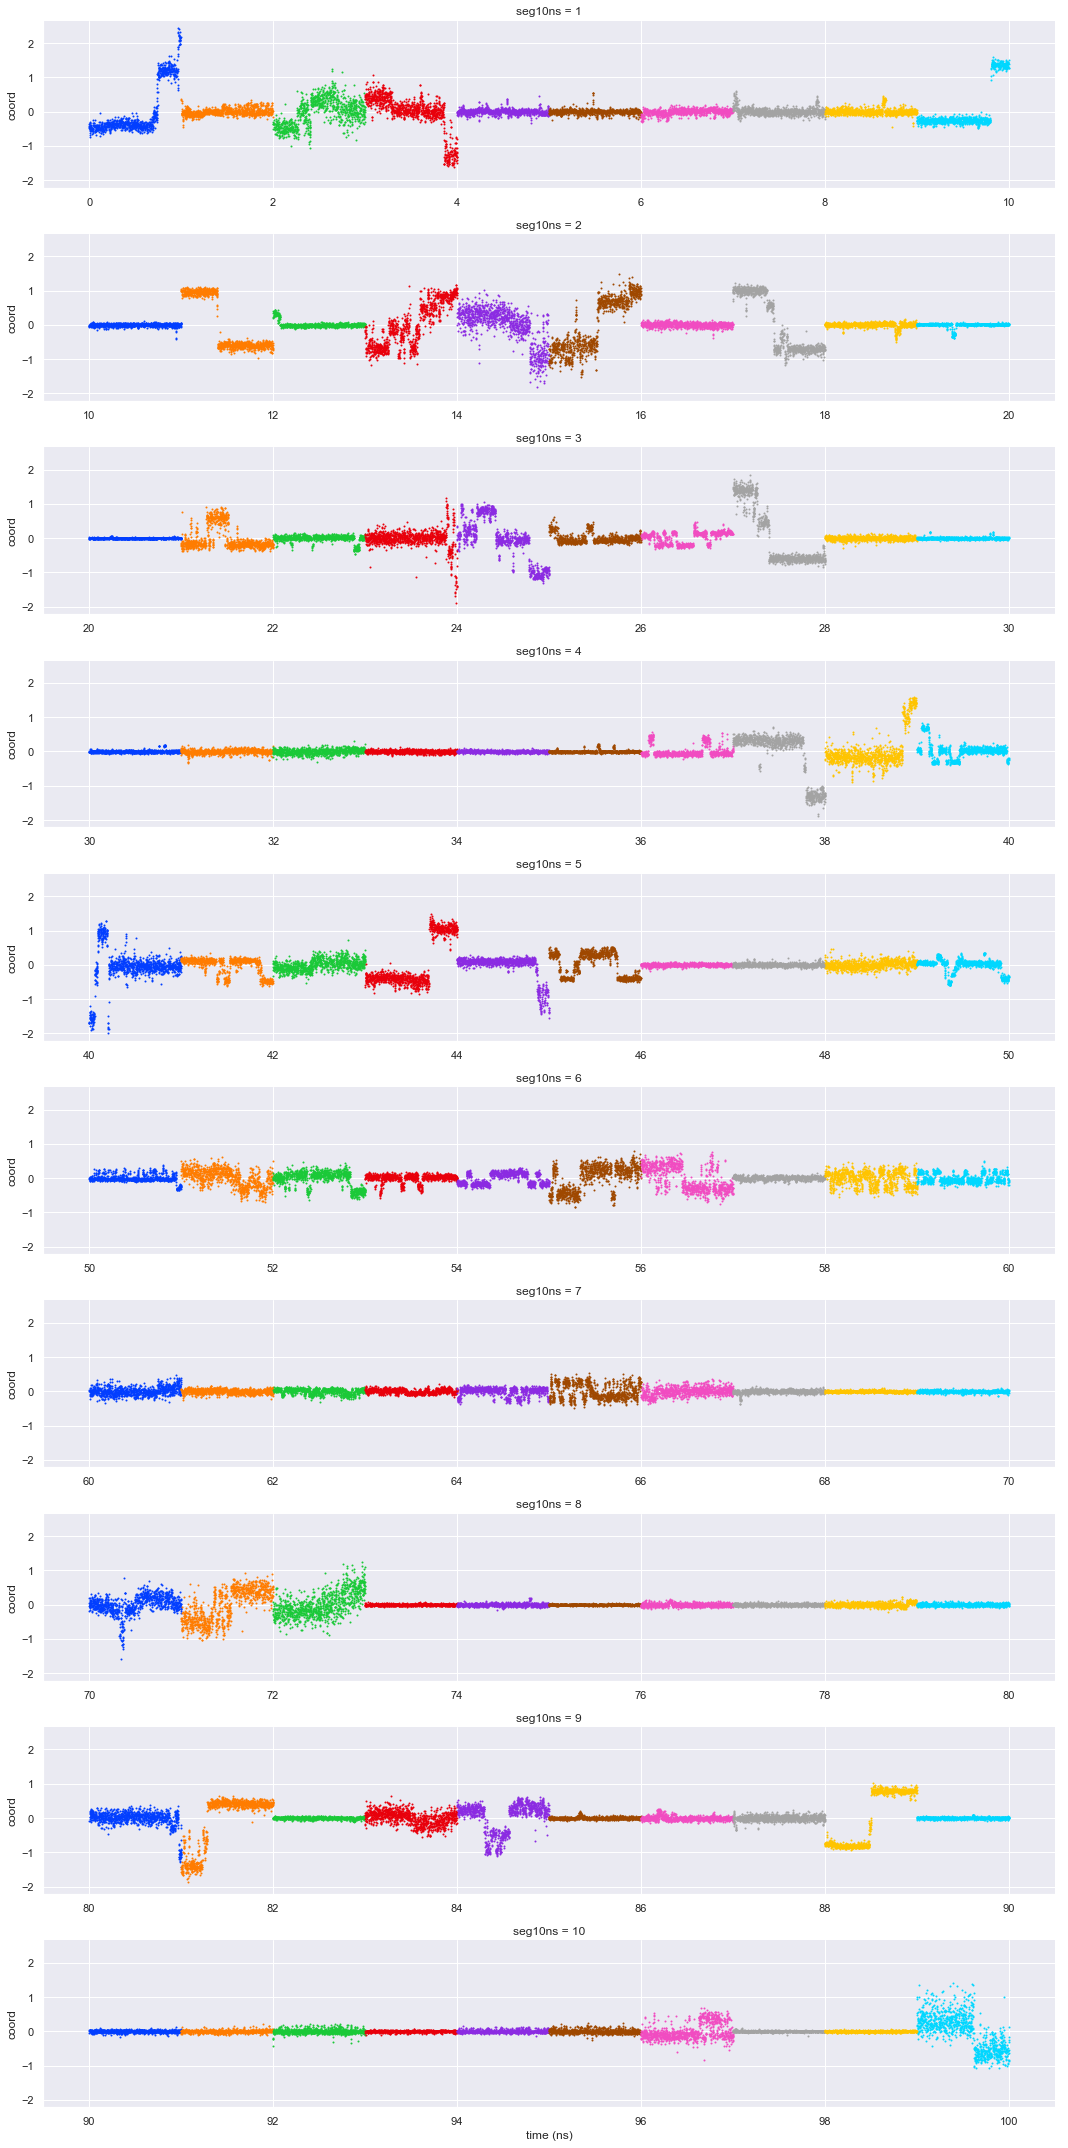

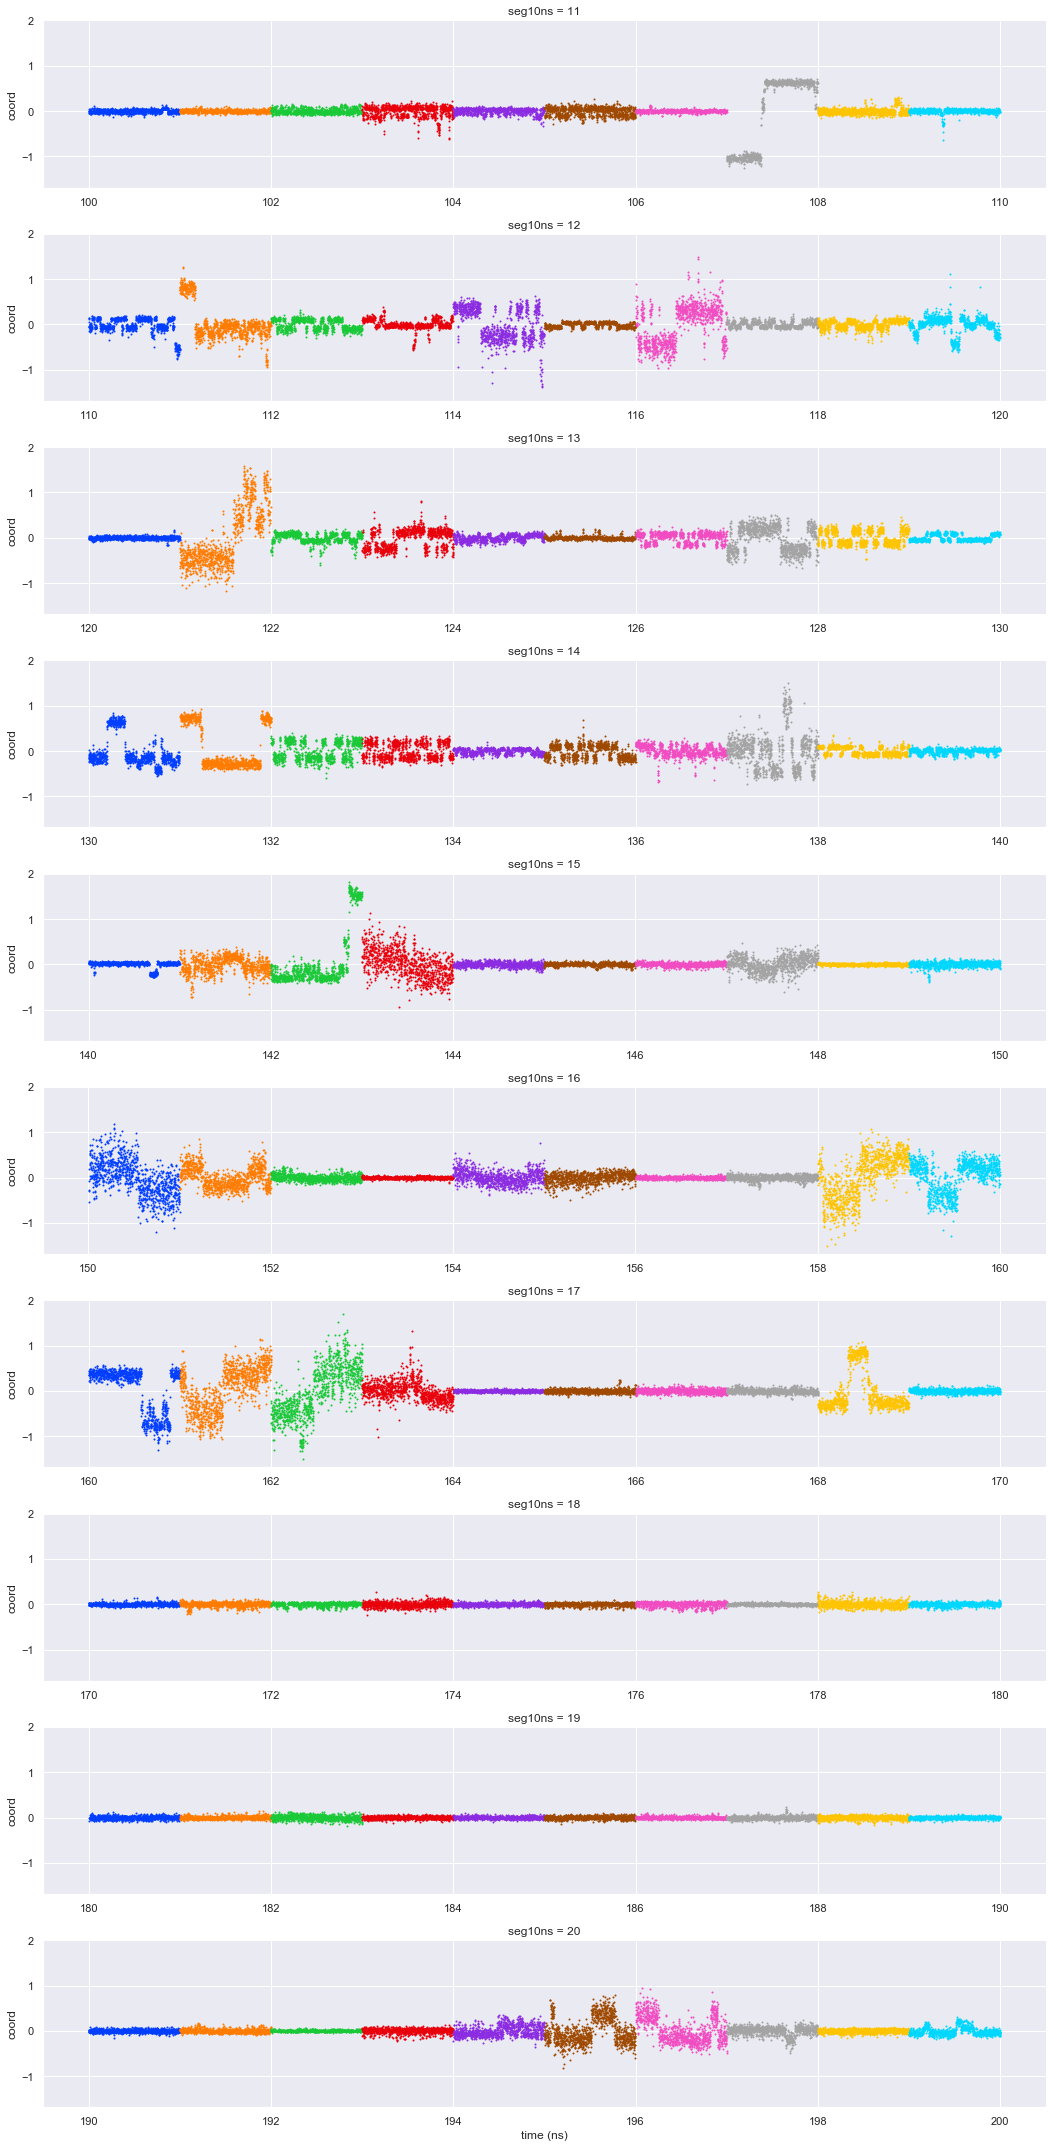

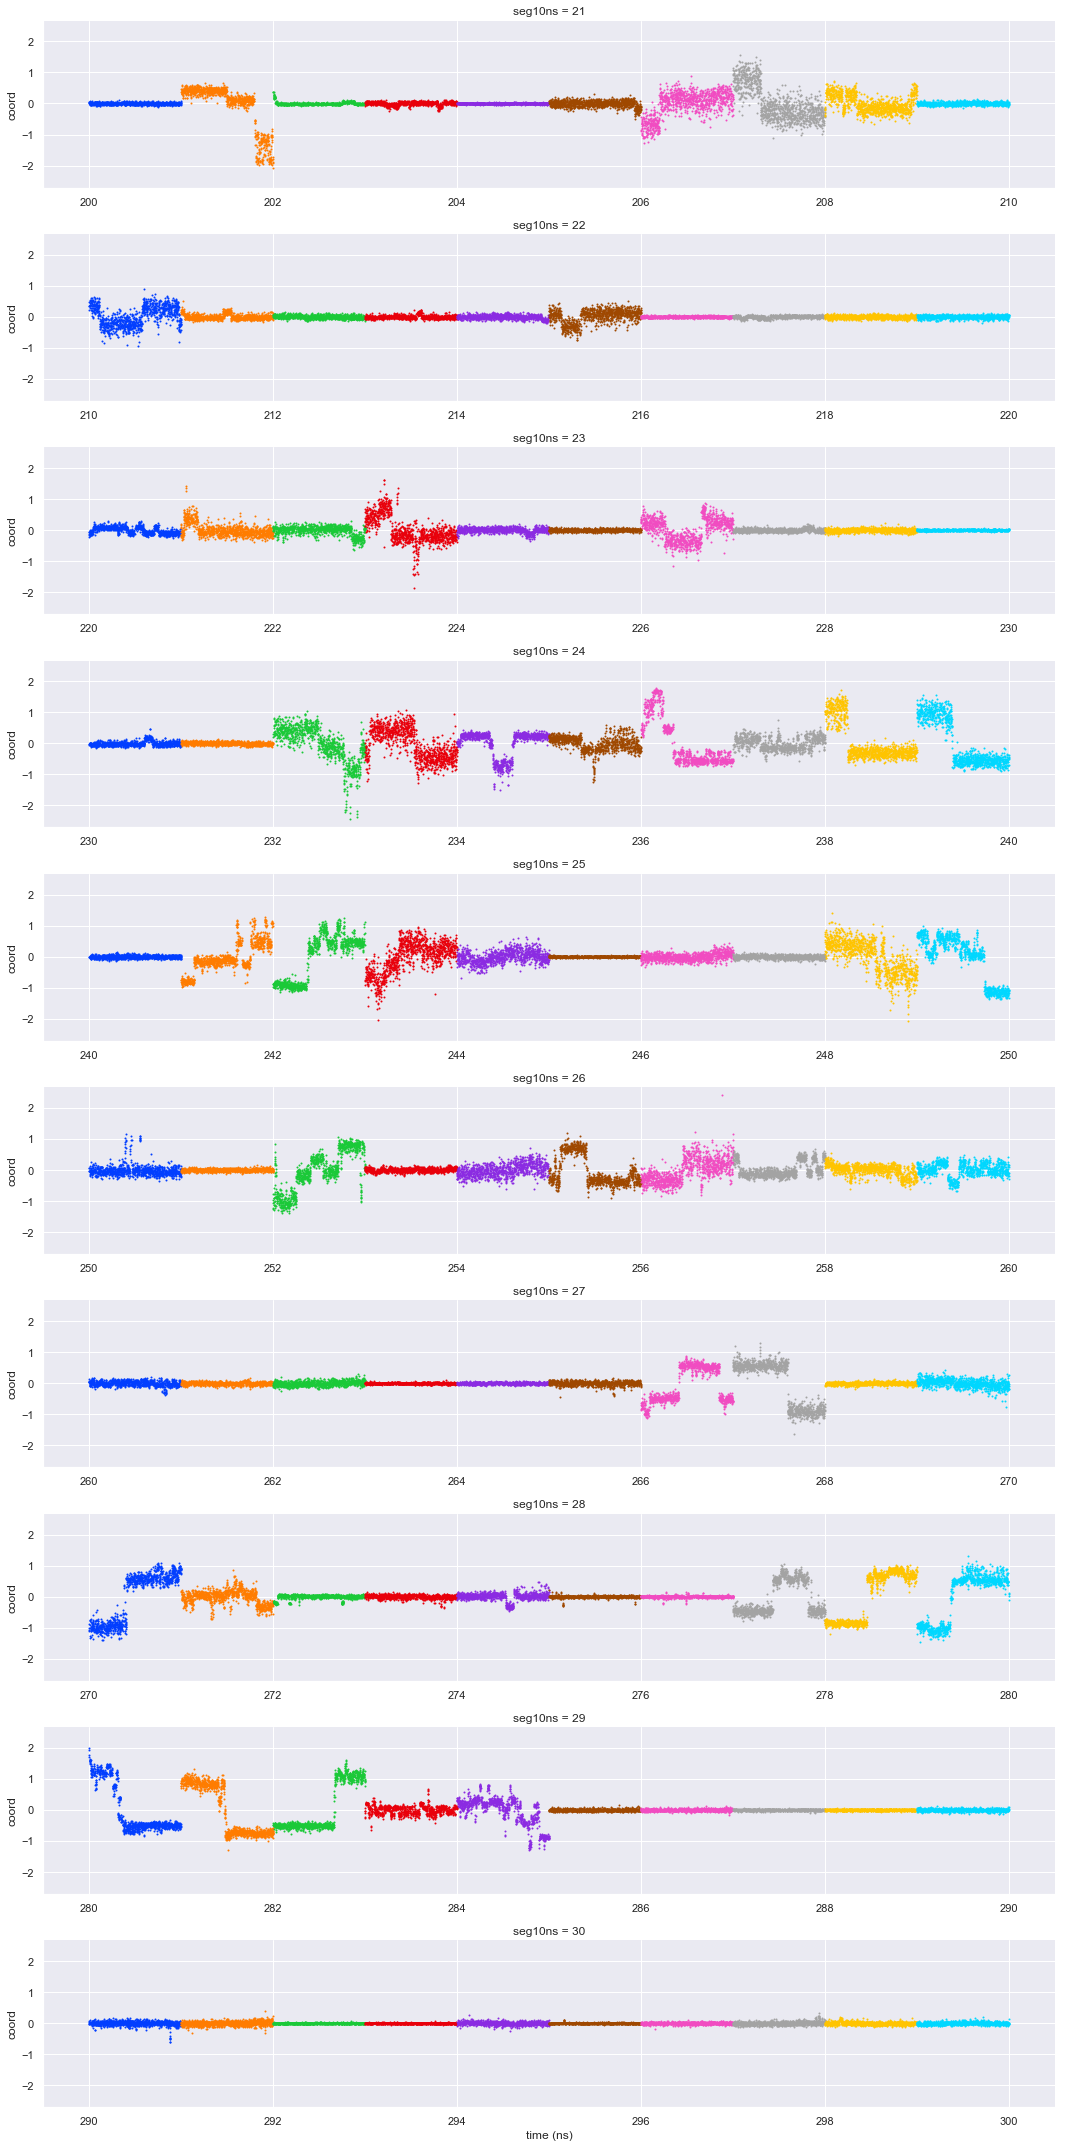

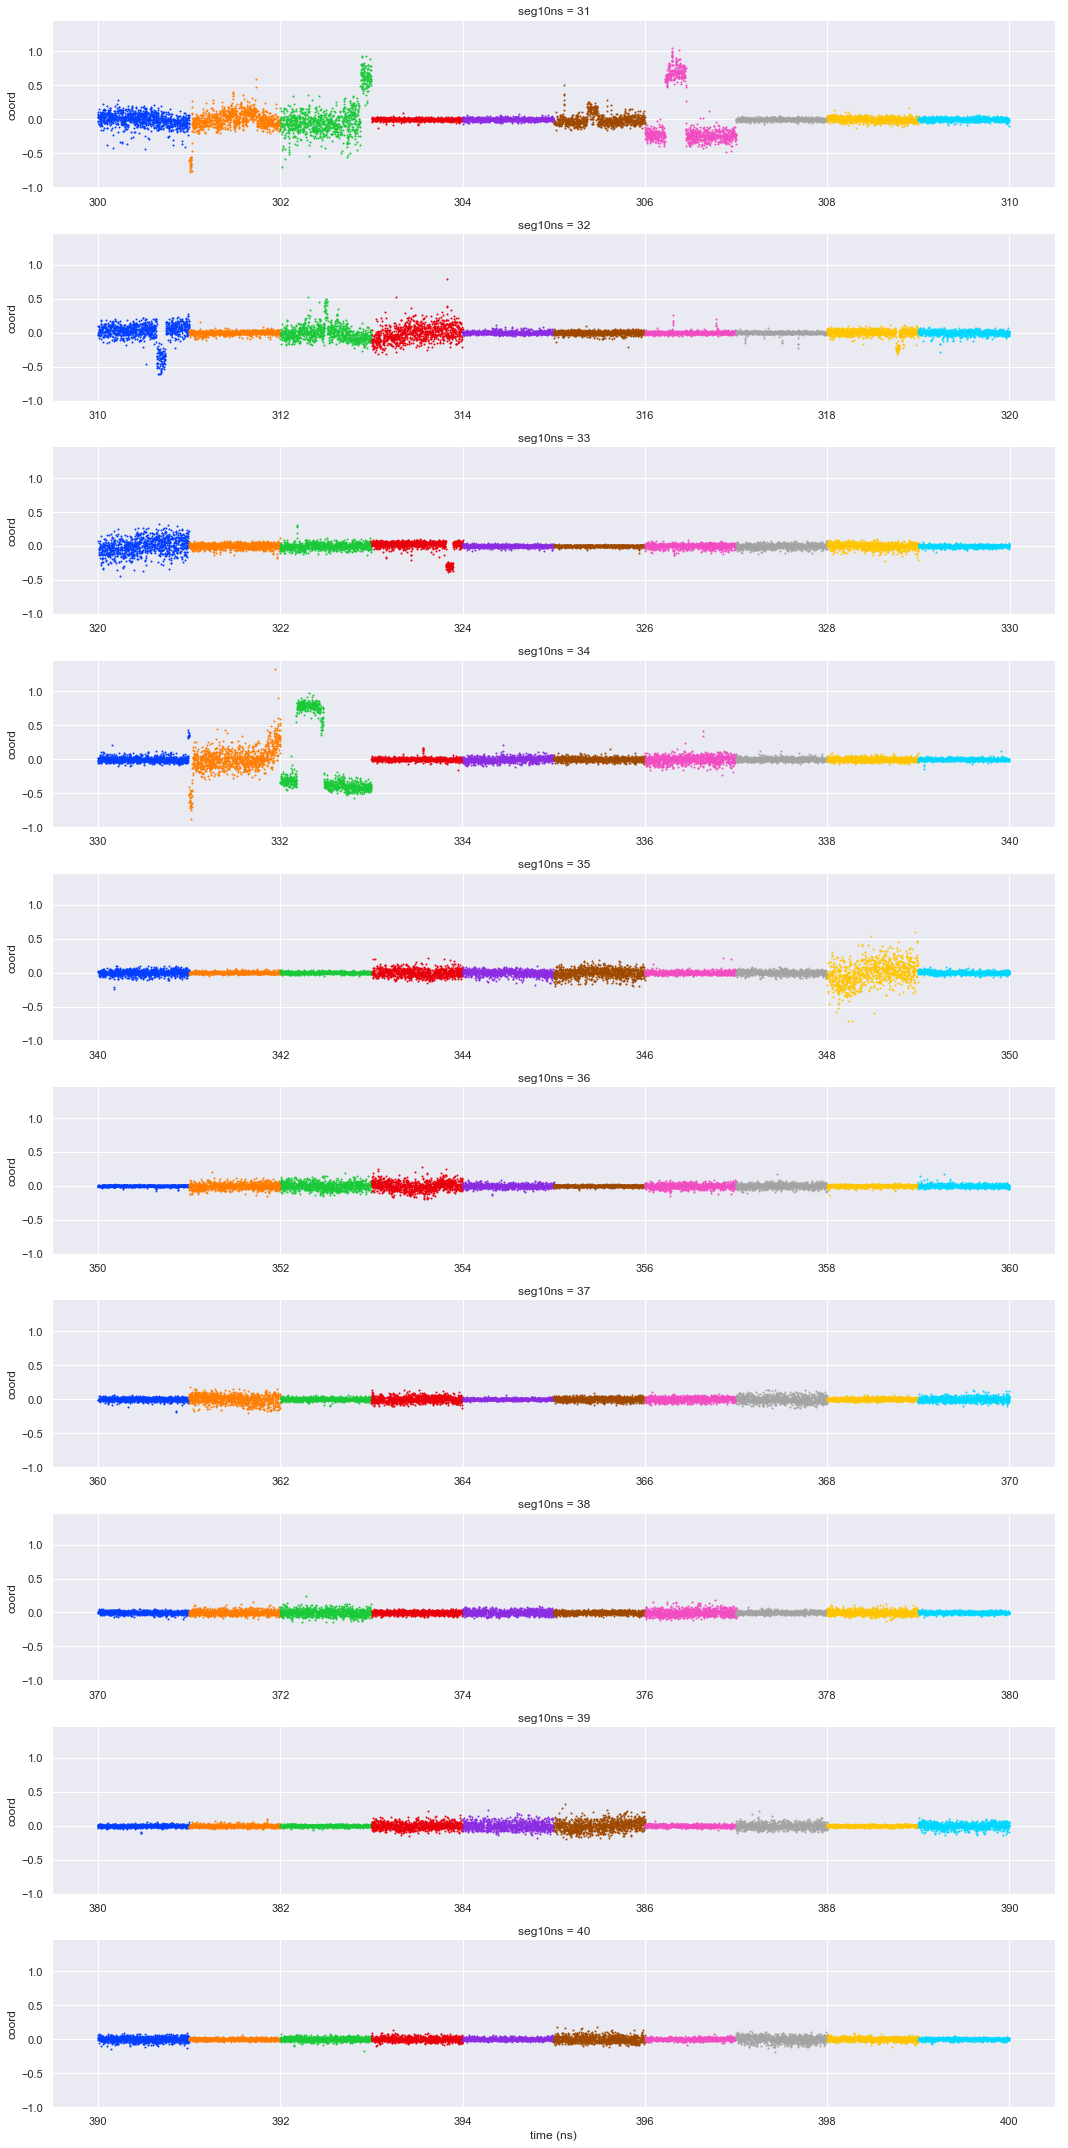

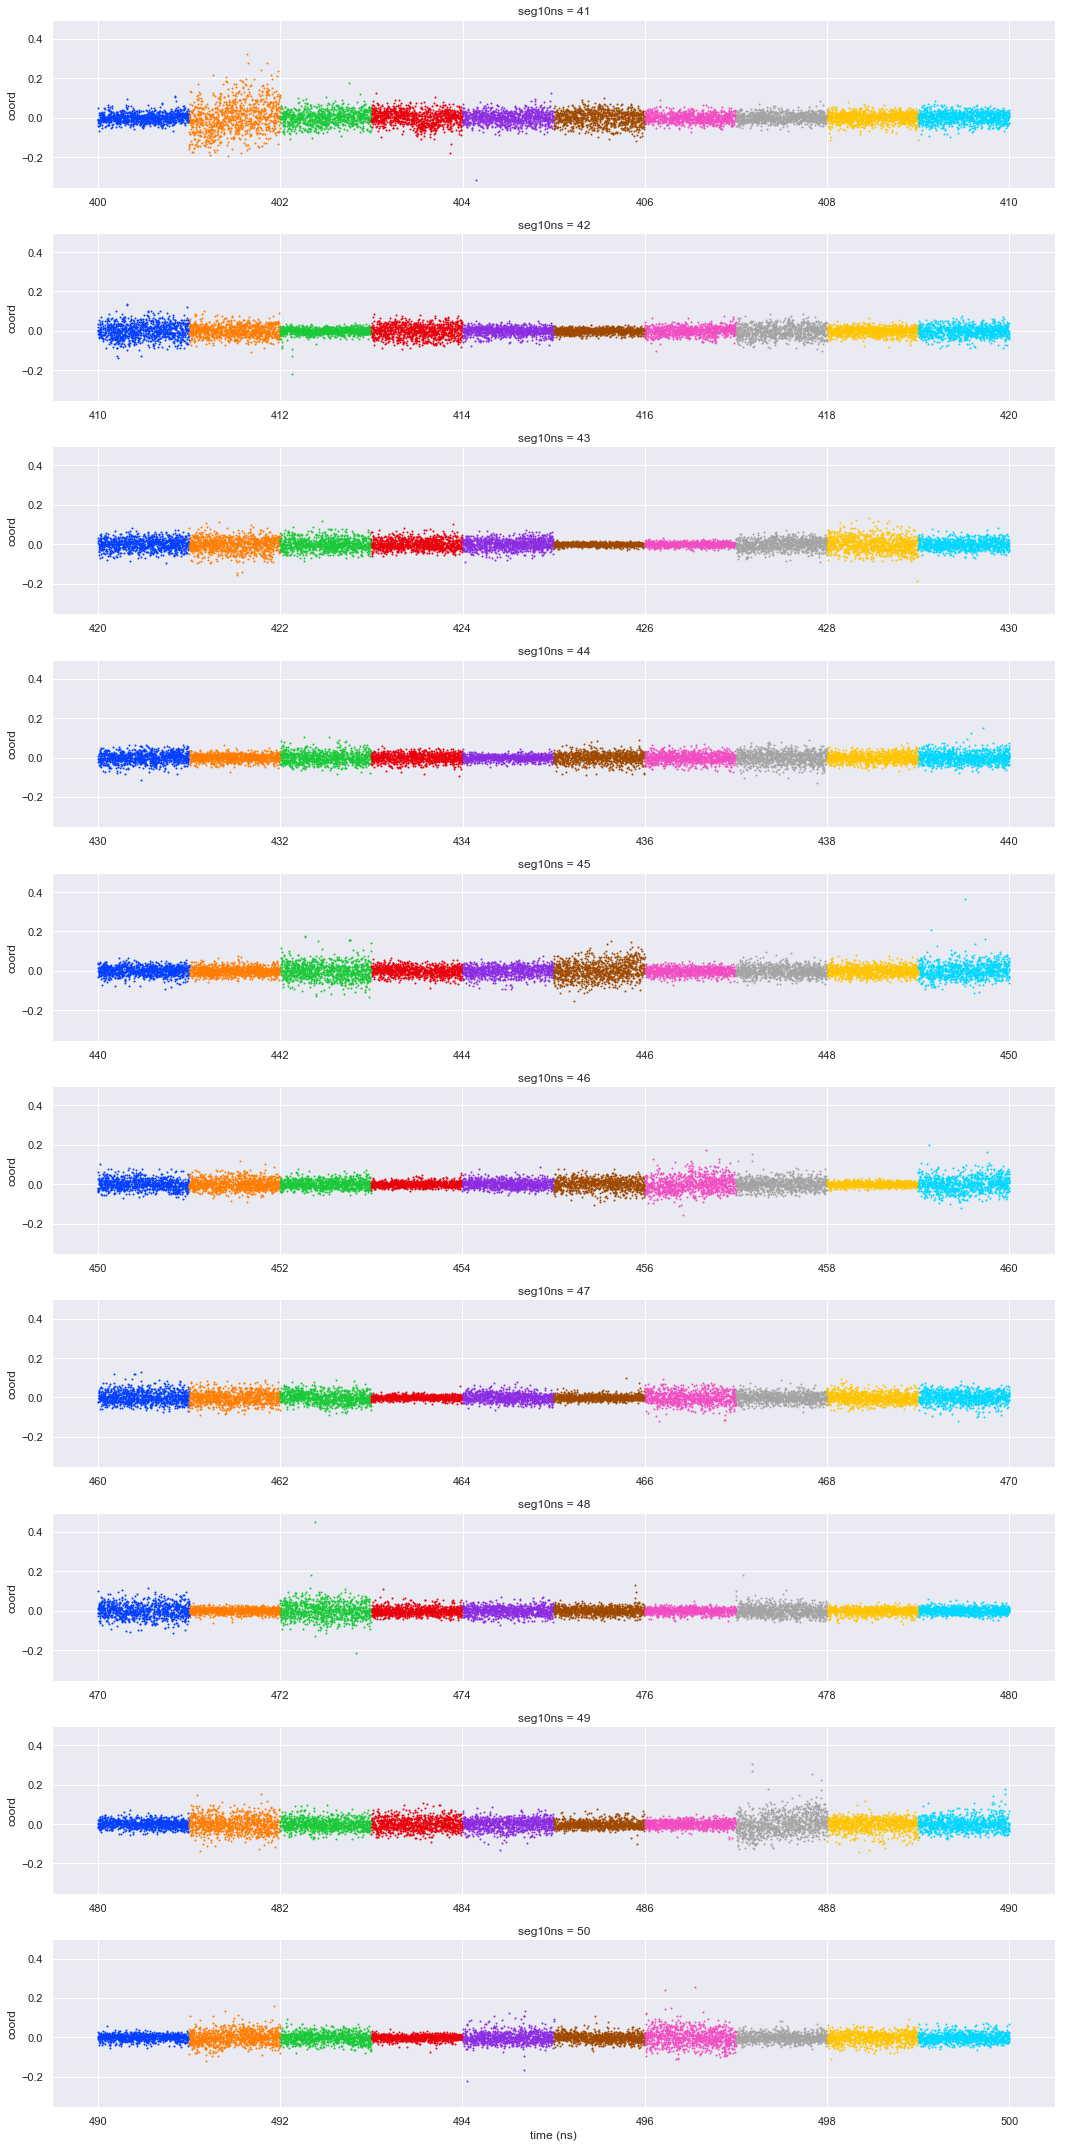

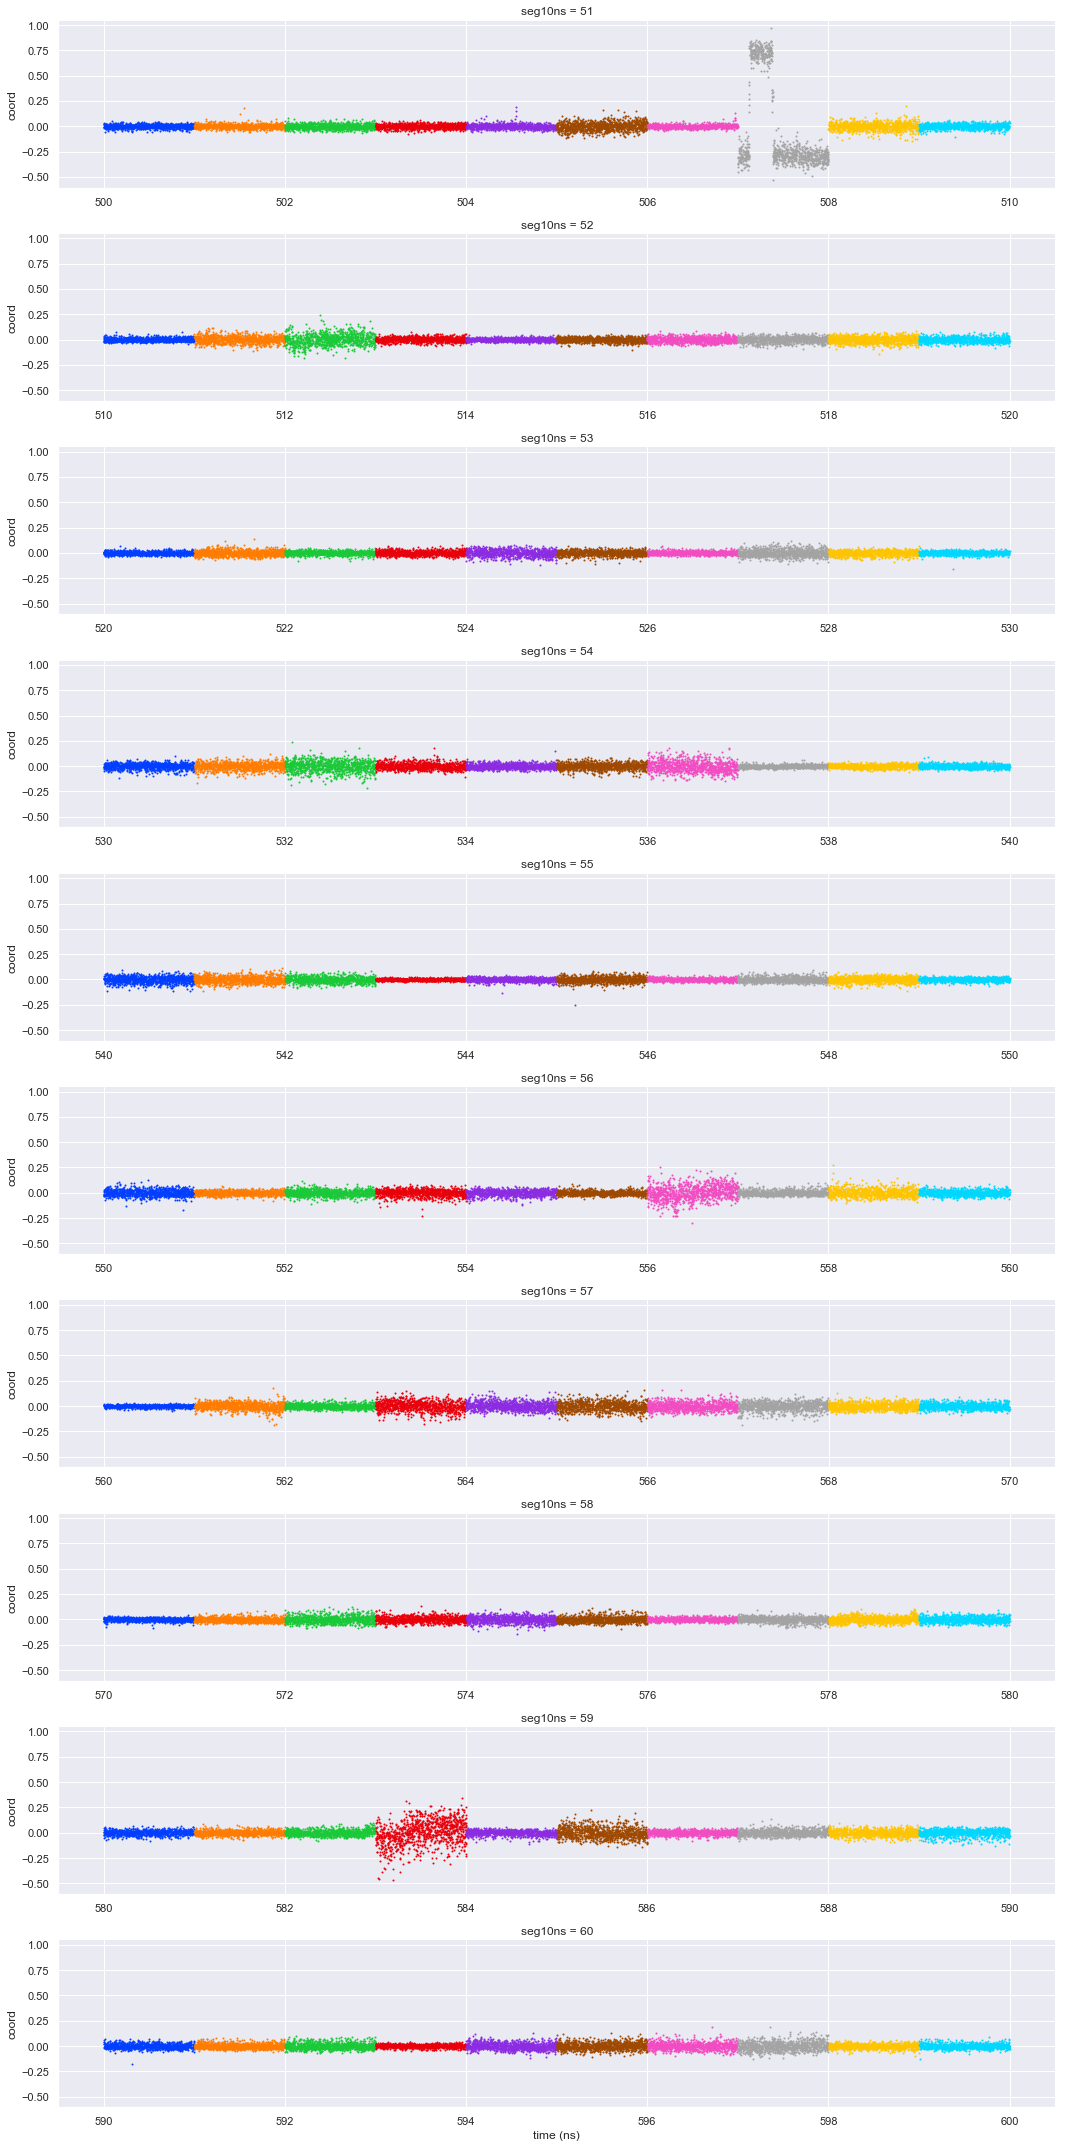

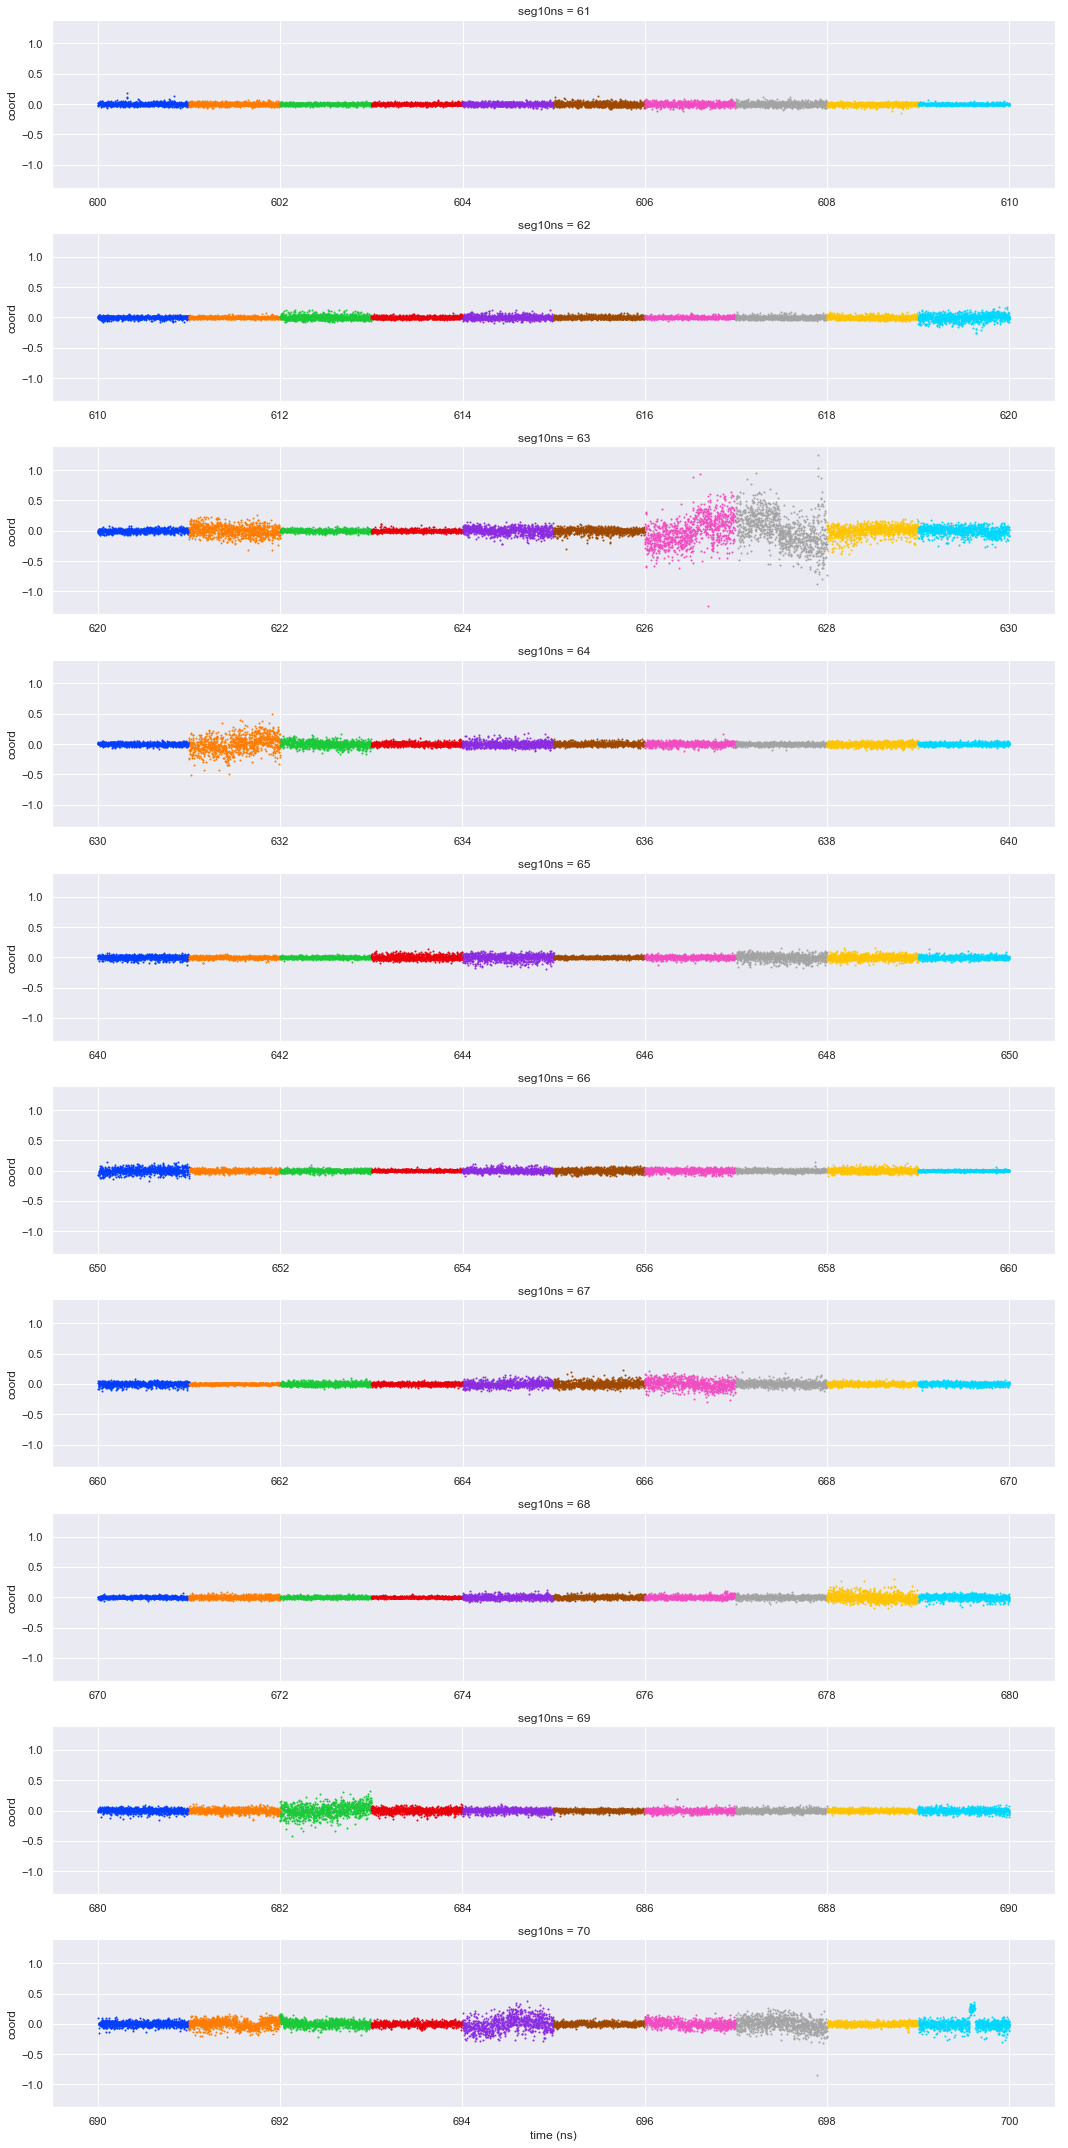

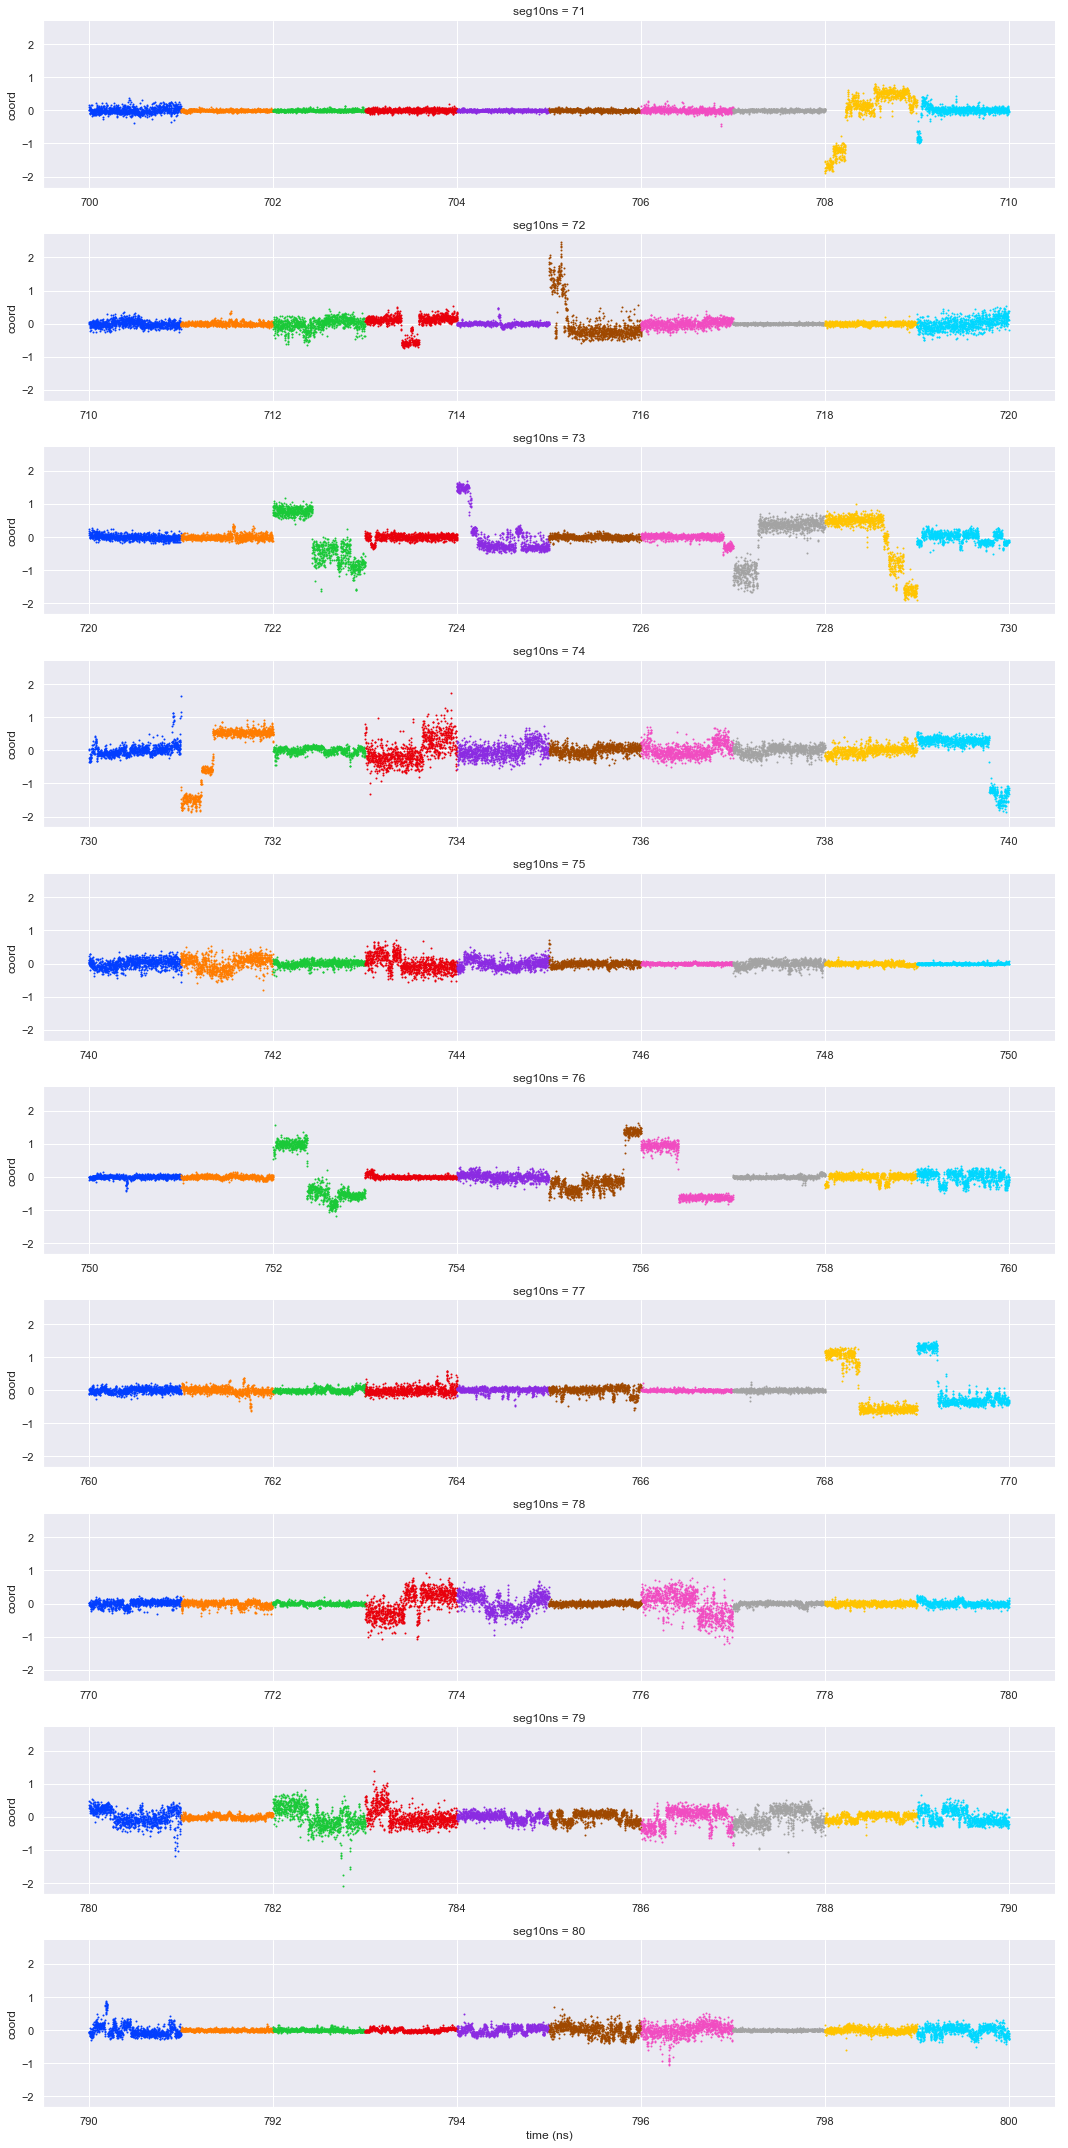

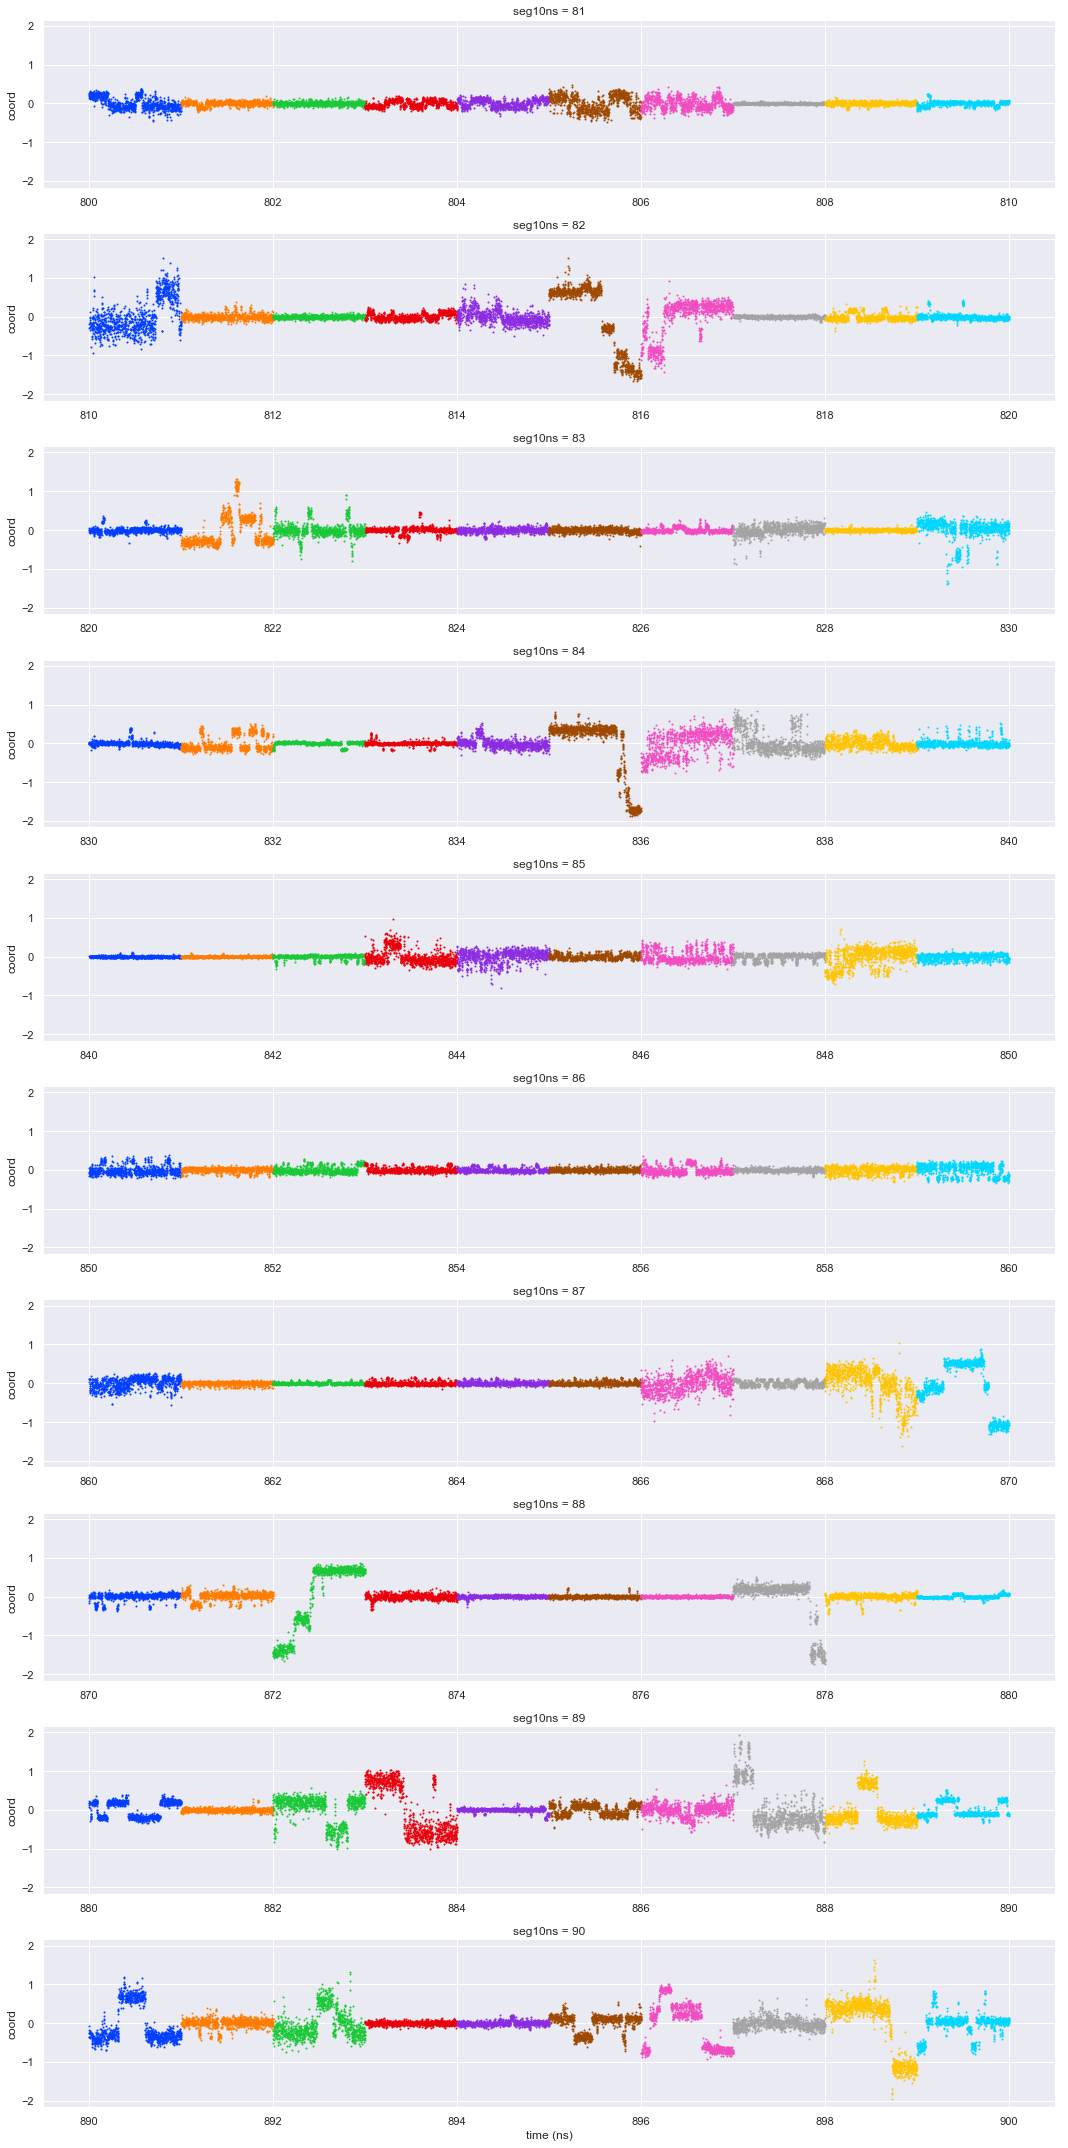

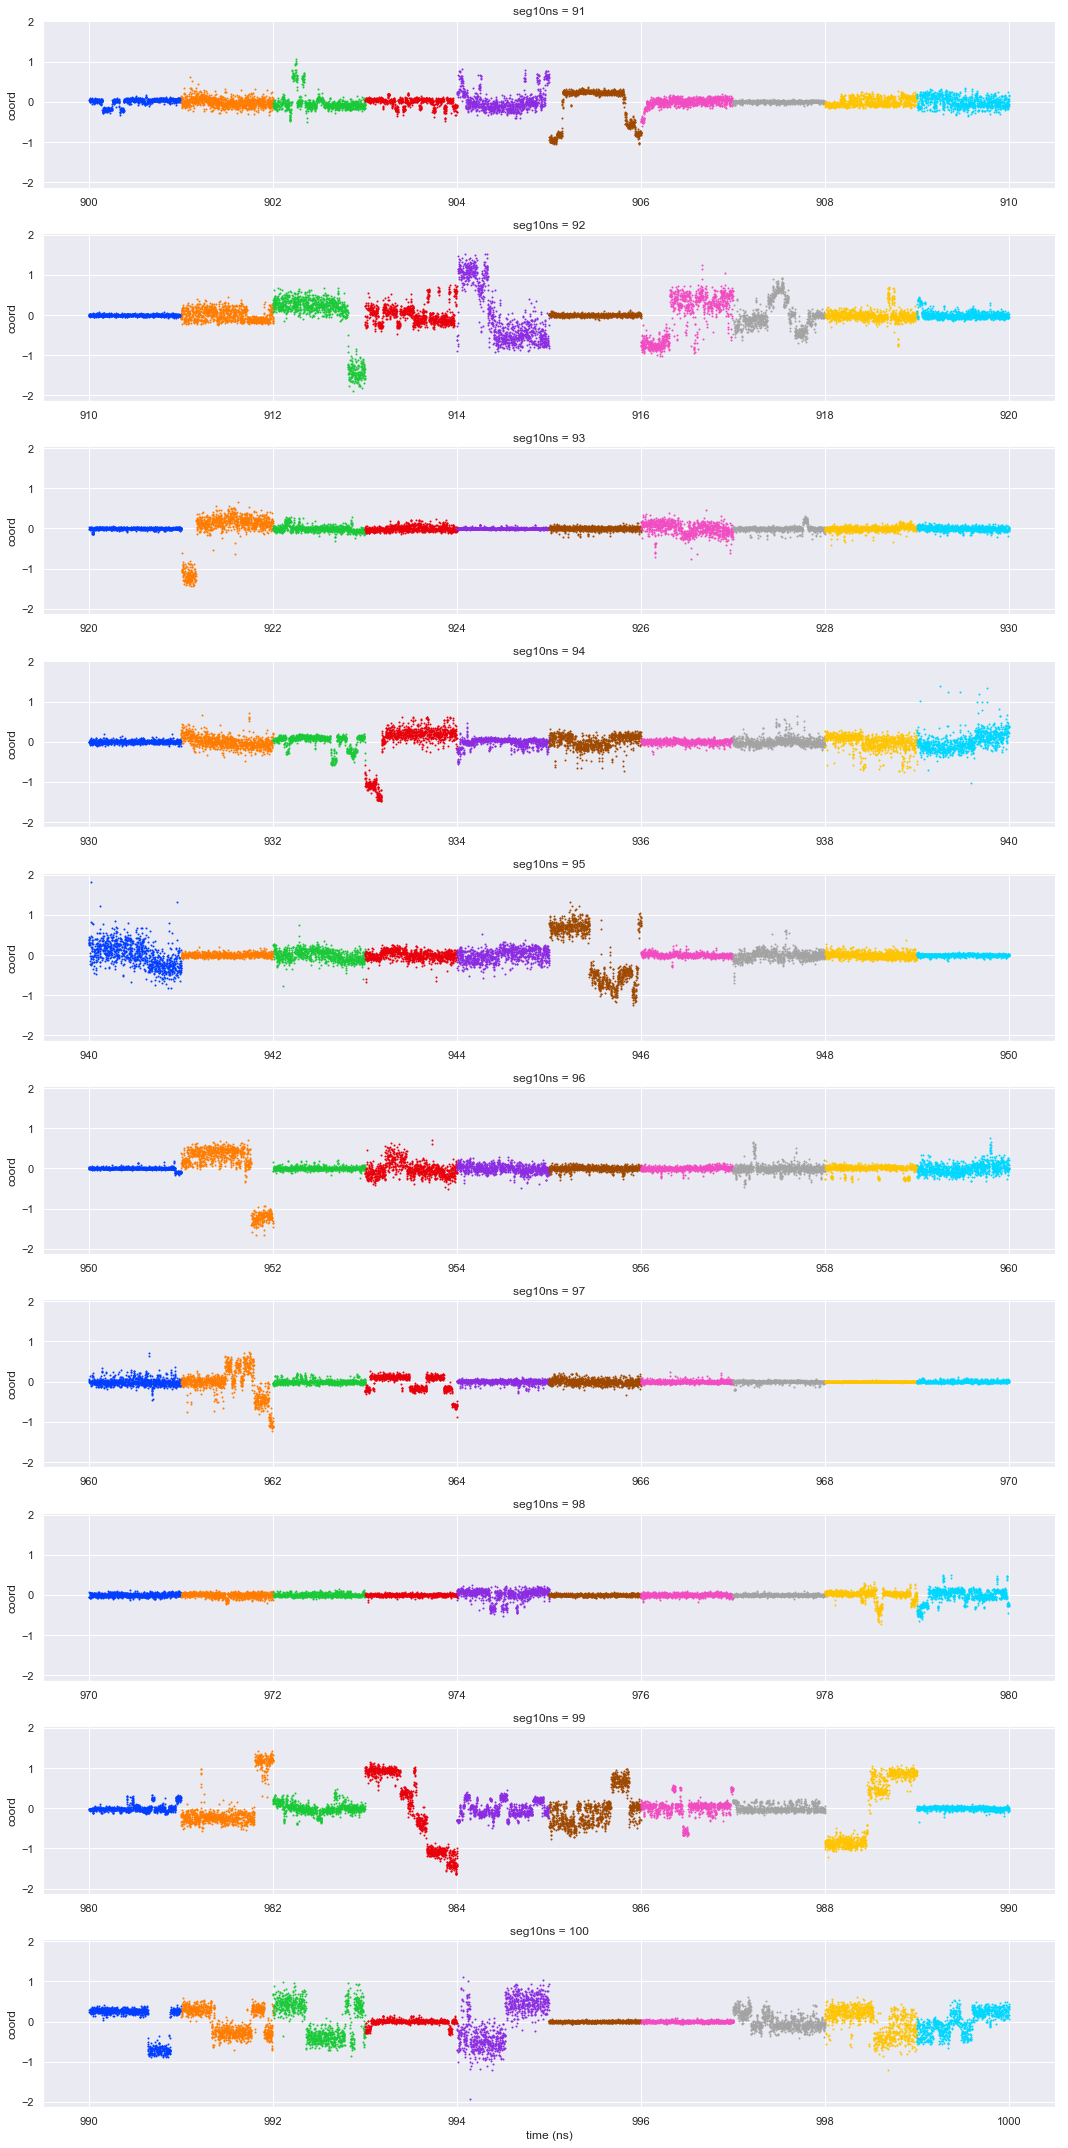

In [40]:
# import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})
df_all['seg10ns'] = (df_all['seg']-1)//10 + 1
df_all['seg100ns'] = (df_all['seg10ns']-1)//10 + 1

for seg in np.arange(10)+1:

    idx = (df_all['projection'] == 'tica') & (df_all['coord']=='1') & (df_all['seg100ns'] == seg)
    g = sns.FacetGrid(df_all.loc[idx,:].sample(frac=0.1), row='seg10ns', 
                      sharex=False, aspect=5, hue='seg', palette='bright')
    g.map(plt.scatter, 't', 'value', alpha=1, s=1)
    g.set_axis_labels('time (ns)', 'coord')
    plt.savefig('traj_3-tica1-seg{}.png'.format(seg))